In [21]:
import torch
import cv2
import numpy as np
from path import Path
from utils import generate
import  matplotlib.pyplot as plt
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from utils import generate
from torchvision import transforms, datasets, models
from PIL import Image
CUDA_LAUNCH_BLOCKING=1 

In [19]:
generate(num = 5000,crop_size_h = 256, crop_size_w = 256,string = 'xian',same_scale = False)

256 256
./BDCI2017-seg/CCF-training-Semi/1.png
./BDCI2017-seg/CCF-training-Semi/1_class_vis.png
(5142, 5664, 3) (5142, 5664, 3)
(5142, 5664, 3) (5142, 5664, 3)
./BDCI2017-seg/CCF-training-Semi/2.png
./BDCI2017-seg/CCF-training-Semi/2_class_vis.png
(2470, 4011, 3) (2470, 4011, 3)
(2470, 4011, 3) (2470, 4011, 3)
./BDCI2017-seg/CCF-training-Semi/3.png
./BDCI2017-seg/CCF-training-Semi/3_class_vis.png
(6116, 3357, 3) (6116, 3357, 3)
(6116, 3357, 3) (6116, 3357, 3)
./BDCI2017-seg/CCF-training-Semi/4.png
./BDCI2017-seg/CCF-training-Semi/4_class_vis.png
(7939, 7969, 3) (7939, 7969, 3)
(7939, 7969, 3) (7939, 7969, 3)
./BDCI2017-seg/CCF-training-Semi/5.png
./BDCI2017-seg/CCF-training-Semi/5_class_vis.png
(7939, 7969, 3) (7939, 7969, 3)
(7939, 7969, 3) (7939, 7969, 3)
55926
55926
55926
55926
55926


In [22]:

object_file = '256_no_scale'
path_lbl = Path(f'{object_file}/label/five_label/')
path_img = Path(f'{object_file}/img/')
fnames = get_image_files(Path(f'{object_file}/img/'))
lbl_names = get_image_files(Path(f'{object_file}/label/five_label/'))

valid_path_img = Path(f'{object_file}/valid/')
valid_path_lbl = Path(f'{object_file}/valid_label/five_label/')


In [23]:
img_f = fnames[2]
img = open_image(img_f)
# img.show(figsize=(5,5))


get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'
valid_get_y_fn = lambda x: valid_path_lbl/f'{x.stem}{x.suffix}'

mask = open_mask(get_y_fn(img_f))
# mask.show(figsize=(5,5), alpha=1)
src_size = np.array(mask.shape[1:])
# src_size,mask.data
print(np.unique(mask.data))

[0 1 2 3]


In [24]:
mask.data.shape

torch.Size([1, 256, 256])

In [4]:

# size = src_size//2
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11166MB of GPU RAM free


In [5]:
codes =['Void','grass','road','building','water']

src = (SegmentationItemList.from_folder(path_img)
        .split_none()
#        .split_by_folder(train='img', valid='valid')
       .label_from_func(get_y_fn, classes=codes))

src_valid = (SegmentationItemList.from_folder(valid_path_img)
        .split_none()
       .label_from_func(valid_get_y_fn, classes=codes))

src.valid = src_valid.train

data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .add_test_folder()   
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [6]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def  iou(input, target,classes = 0):
    metric = []
    input, target = input.cpu().numpy(), target.cpu().numpy()

    intersection = np.logical_and(target == classes, input == classes)
    union = np.logical_or(target == classes , input == classes)
    iou_score = np.sum(intersection) / np.sum(union)
    metric.append(iou_score)
    return  iou_score

    
class IOU(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self,classes, name ):
        super().__init__()
        self.classes = classes
        self.name = name
    def on_epoch_begin(self, **kwargs): 
        self.output, self.target = [], []
        self.val, self.count = 0.,0

    def on_batch_end(self, last_target, last_output,**kwargs):
            n = last_target.shape[0]
            last_output = last_output.argmax(dim=1).view(n,-1)
            last_target = last_target.view(n,-1)
            self.val += iou(last_output,last_target, self.classes)
            self.count += 1

                

    def on_epoch_end(self, last_metrics,**kwargs):

        return add_metrics(last_metrics, self.val/self.count)


bckgroud = IOU(classes = 0, name = 'bckgroud')
building = IOU(classes = 1, name = 'building')
grass = IOU(classes = 3, name = 'grass')
road = IOU(classes = 4, name = 'road')





In [7]:
wd=1e-2
metrics=[acc_camvid,bckgroud,building,grass,road]


In [8]:
learn = unet_learner(data, models.resnet34, wd=wd,metrics=metrics)
# learn.load('/home/shiyi/beshe/fastai_model/same_scale_512_stage-2');


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


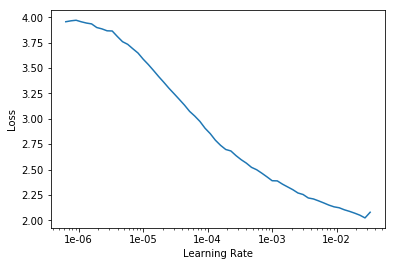

In [112]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,bckgroud,building,grass,road,time
0,0.216471,5.168299,0.058340,0.380737,0.019211,0.038097,0.000000,24:23


In [16]:
learn.recorder.metric()

NameError: name 'learn' is not defined

In [23]:
learn.save('/home/shiyi/beshe/record_model/256_no_scale_with_xian_test')


In [ ]:
lr=5e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.294965,0.274450,0.902535,00:31
1,0.294887,0.276667,0.909924,00:31
2,0.297045,0.276774,0.912445,00:31


In [ ]:
learn.save('/home/shiyi/beshe/fastai_model/same_scale_512_stage-1')


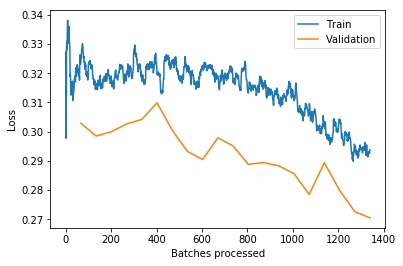

In [38]:
learn.recorder.plot_losses()

In [87]:
learn.load('/home/shiyi/beshe/fastai_model/512_stage-1-big');


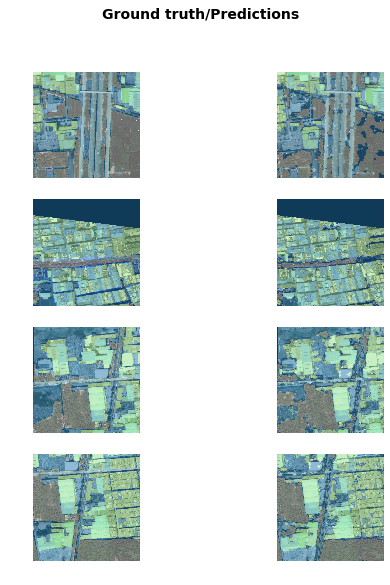

In [22]:
learn.show_results(rows=4, figsize=(8,9))


In [23]:
learn.unfreeze()


In [ ]:
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(20, lrs, pct_start=0.8)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.323348,0.302897,0.891186,00:31
1,0.315155,0.298505,0.889875,00:31
2,0.319028,0.299968,0.891183,00:32
3,0.319056,0.302655,0.888935,00:31
4,0.318795,0.304195,0.888151,00:32
5,0.321369,0.309897,0.896142,00:31
6,0.324487,0.300504,0.903409,00:32
7,0.321014,0.293270,0.893862,00:31
8,0.322227,0.290460,0.884701,00:32
9,0.318910,0.297901,0.876676,00:32


In [ ]:
learn.save('/home/shiyi/beshe/fastai_model/same_scale_512_stage-2')


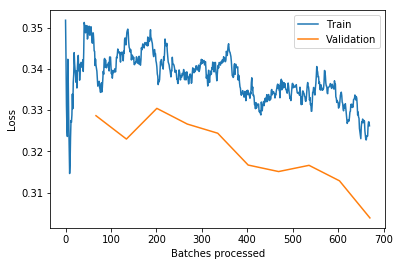

In [36]:
learn.recorder.plot_losses()

In [17]:

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 11166MB of GPU RAM free


In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.load('/home/shiyi/beshe/fastai_model/same_scale_512_stage-2');
# lr_find(learn)
# learn.recorder.plot()


In [41]:
lr=5e-4

learn.fit_one_cycle(10, slice(lr), pct_start=0.8)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.265623,0.243968,0.917983,00:31
1,0.275202,0.247796,0.915513,00:31
2,0.272498,0.246894,0.922498,00:31
3,0.271408,0.251581,0.927117,00:32
4,0.270112,0.246473,0.905302,00:32
5,0.270236,0.240341,0.927664,00:32
6,0.281895,0.252087,0.937043,00:32
7,0.271060,0.239650,0.920175,00:31


KeyboardInterrupt: 

In [42]:
learn.save('/home/shiyi/beshe/fastai_model/retrain_512_stage-1-big')


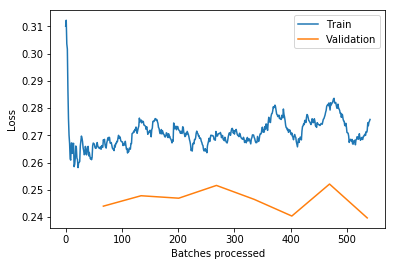

In [43]:
learn.recorder.plot_losses()

In [ ]:
image = open_image('data/tempppppp.png')
pred = learn.predict(image)[1]

In [17]:
learn.load('/home/shiyi/beshe/fastai_model/same_scale_512_stage-2');


In [47]:
image = open_image('labelme/map_0_0_json/img.png')
pred = learn.predict(image)[1]

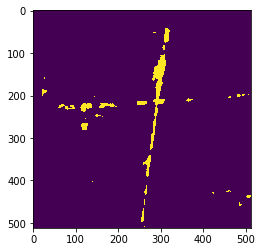

In [126]:
plt.imshow(pred.numpy().reshape(512,512) == 4)
input = pred.numpy().reshape(512,512)

In [138]:
# ### label not same need to convert 
# 3 绿地
# 4 路
temp = Image.open('labelme/map_0_0_json/label.png')
temp = np.array(temp)
temp[temp == 3] = 4
temp[temp == 2] = 3

In [153]:
def  iou(input, target):
    metric = []
    for i in np.unique(input):

        intersection = np.logical_and(target == i, input == i)
        union = np.logical_or(target == i , input == i)
        iou_score = np.sum(intersection) / np.sum(union)
        metric.append(iou_score)
        print(iou_score)
    return  np.mean(metric)

In [ ]:
iou(input,temp)

In [148]:
np.unique(temp)

array([0, 1, 3, 4], dtype=uint8)

In [63]:
temp = Image.open('data/label/five_label/picture_0_0.png')

In [64]:
temp = np.array(temp)

In [66]:
np.unique(temp)

array([0, 1, 3, 4], dtype=uint8)

In [159]:
stride = 512
image_size = 512

#image = cv2.imread('BDCI2017-seg/CCF-training-Semi/3.png')
#image = cv2.imread('Xian_30cm_15May2018_R1C1_enhanced.tif')
image = cv2.imread('labelme/map_0_0_json/img.png')
h,w,_ = image.shape
print(image.shape)
padding_h = (h//stride + 1) * stride 
padding_w = (w//stride + 1) * stride
print(padding_h,padding_w)
padding_img = np.zeros((padding_h,padding_w,3),dtype=np.uint8)
padding_img[0:h,0:w,:] = image[:,:,:]

padding_img = np.array(padding_img)

print ('src:',padding_img.shape)
mask_whole = np.zeros((padding_h,padding_w),dtype=np.uint8)
for i in range(padding_h//stride):
    for j in range(padding_w//stride):
        crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size , :]
        ch,cw,_ = crop.shape

        cv2.imwrite('data/tempppppp.png',crop)
        image = open_image('data/tempppppp.png')
        pred = learn.predict(image)[1]

        pred = pred.data.cpu().numpy()

        mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]

#
from PIL import Image
im = Image.fromarray(mask_whole)
# im.save(f"predict_1_{stride}.png")

(1500, 1500, 3)
1536 1536
src: (1536, 1536, 3)


In [161]:
mask_whole
iou(mask_whole[:1500,0:1500],temp)

0.6393462229437781
0.6830820950235145
0.7526956833243775
0.1306775519119715


0.5514503883009104

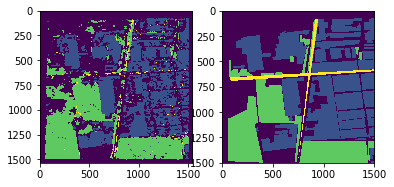

In [163]:
plt.subplot(1,2,1)
plt.imshow(mask_whole)
plt.subplot(1,2,2)
plt.imshow(temp)

In [34]:
z = np. array (mask_whole == 3)
z = z + 0
z = z * 255

In [46]:
z = np. array (mask_whole * 50)

cv2.imwrite('retrain_moreepoch_same_scale_building_512.png', z)

True

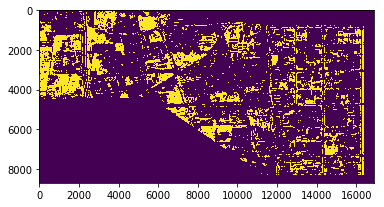

In [35]:
plt.imshow(z)

In [164]:
cv2.imwrite('final.tif',mask_whole)

True

In [156]:
np.unique(mask_whole)

array([  0, 252, 253, 254, 255], dtype=uint8)

In [166]:
np.unique(mask_whole)

array([0, 1, 2, 3, 4], dtype=uint8)

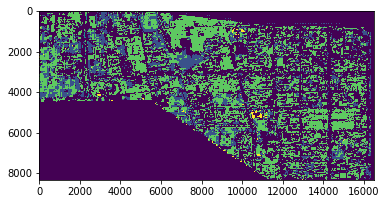

In [162]:
plt.imshow(mask_whole)

In [163]:
plt.savefig('final.png')

<Figure size 432x288 with 0 Axes>

In [64]:
size = 256
src = ImageImageList.from_folder(path_img)
data = (src.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats),trans)

AttributeError: 'ImageImageList' object has no attribute 'transform'

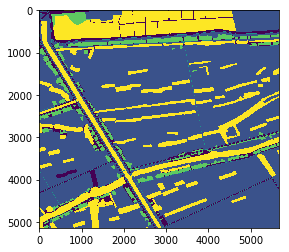

In [45]:
plt.imshow(whole_map)

In [47]:
whole_map.shape

(5142, 5664)

In [ ]:
def change_3_channel_to_1(mask, classes, prefix,index, ran, ):
    label_class = {}
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    (R,G,B) = cv2.split(mask)
    label_class['road'] = B
    label_class['water'] = G & R
    label_class['building'] = G - label_class['water']
    label_class['grass'] = R - label_class['water']
    
    if ran == True:
        string = '_random'
    else:
        string = ''
        
    for item in classes:
        mask = label_class[item]
        cv2.imwrite(f'./data/label/{item}/{prefix}{string}_{index}.png',mask)
